In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tkinter.filedialog import askdirectory
import spm1d

In [2]:
dir_to_read = askdirectory(title = 'Select Directory to Read CMJ Files')
files_to_read = os.listdir(dir_to_read)
print(files_to_read)

['JonathanR-POST.csv', 'JonathanR-PRE.csv', 'MatalinaO-POST.csv', 'MatalinaO-PRE.csv', 'SamS-POST.csv', 'SamS-PRE.csv']


In [58]:
# This is a custom function to read the CMJ data
# Of note, we are cropping the CMJ array from the point of the beginning of the countermovement (start_move) to takeoff (takeoff)
sf = 1000

def read_and_crop_and_interpolate_cmj(file_path):
    full_data = pd.read_csv(file_path)
    fz_total = full_data.iloc[:,3]

    
    # calculate baseline fz ('weighing phase')
    bw_mean = fz_total[0:1000].mean()
    bw_sd = fz_total[0:1000].std()
    
    bodymass = bw_mean/9.81

    # this determines when movement begins
    start_move = 20
    while fz_total[start_move] > (bw_mean - (bw_sd*10)):
        start_move = start_move + 1

    # identify takeoff index of original dataframe as when force drops below 30 N    
    takeoff = start_move
    while fz_total[takeoff] > 30:
        takeoff = takeoff + 1
        
    # crop the array from start movement to takeoff
    cropped_fz_total_original = fz_total[start_move:takeoff]
    
    # normalize to bodymass in kilos so N/kg is comparable between subjects
    cropped_fz_normalized = cropped_fz_total_original/bodymass
    
    # interpolate to 101 datapoints
    original_data = np.linspace(0, len(cropped_fz_normalized)-1, len(cropped_fz_normalized))
    interpolated_indices = np.linspace(0, len(cropped_fz_normalized)-1, 101)
    force_interpolated = np.interp(interpolated_indices, original_data, cropped_fz_normalized)
    
    # return the array
    return(force_interpolated)
    


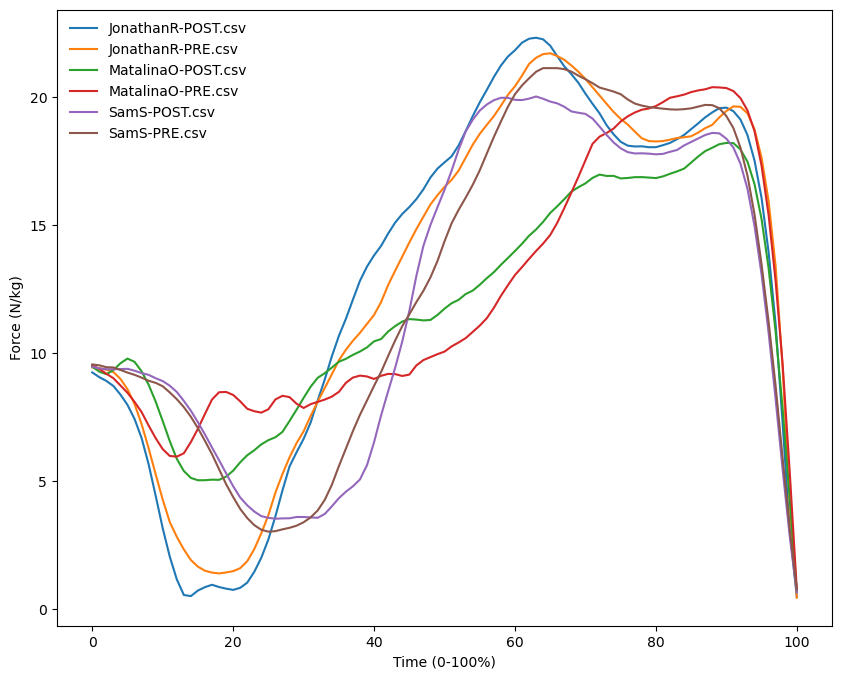

In [116]:
# now apply that function in a for loop
data_to_save = pd.DataFrame()

# initalize a plot
plt.figure(figsize = (10, 8))

for file_name in files_to_read:
    file_path_of_choice = os.path.join(dir_to_read, file_name)
    cleaned_and_interpolated_data = read_and_crop_and_interpolate_cmj(file_path=file_path_of_choice)
    
    # append the dataframe with the values we just generated...
    data_to_save[file_name] = cleaned_and_interpolated_data
    
    # plot the data for sanity checks. always. 
    plt.plot(cleaned_and_interpolated_data, label = file_name)

# outside of the loop, figure theme settings
plt.legend(loc = 'upper left', frameon = False)
plt.ylabel('Force (N/kg)')
plt.xlabel('Time (0-100%)');

The next chunk will create the two arrays we will be looking at - PRE vs. POST.
<ol>
<li> First, filter the dataframes into post_df and pre_df based on column names
<li> Then transpose the dataframes into a J x Q matrix (subjects X nodes/points per trial)
<li> Lastly, transfer the dataframe into an array for ease. 


In [61]:
post_df = data_to_save.loc[:, data_to_save.columns.str.contains('POST')]
pre_df = data_to_save.loc[:, data_to_save.columns.str.contains('PRE')]

post_transpose = post_df.T
pre_transpose = pre_df.T

y1 = np.array(post_transpose)
y0 = np.array(pre_transpose)

In [44]:
t = spm1d.stats.ttest_paired(y0, y1)
ti = t.inference(alpha = 0.05)
ti

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 2)
   SPM.fwhm      :  7.09675
   SPM.resels    :  (1, 14.09095)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  44.92772
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()



Text(40.0, 45.444389898564914, '$\\alpha$=0.05:  $t^*$=44.928')

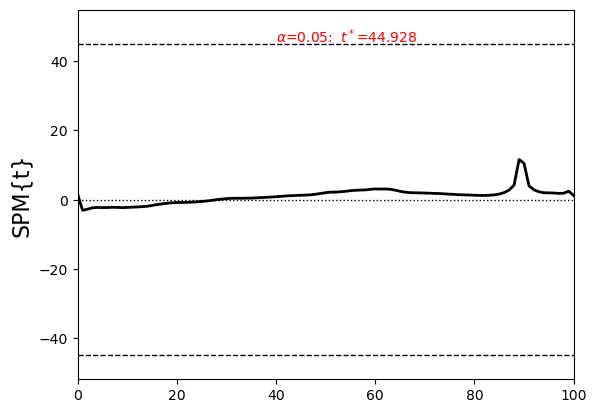

In [45]:
ti.plot()
ti.plot_threshold_label()

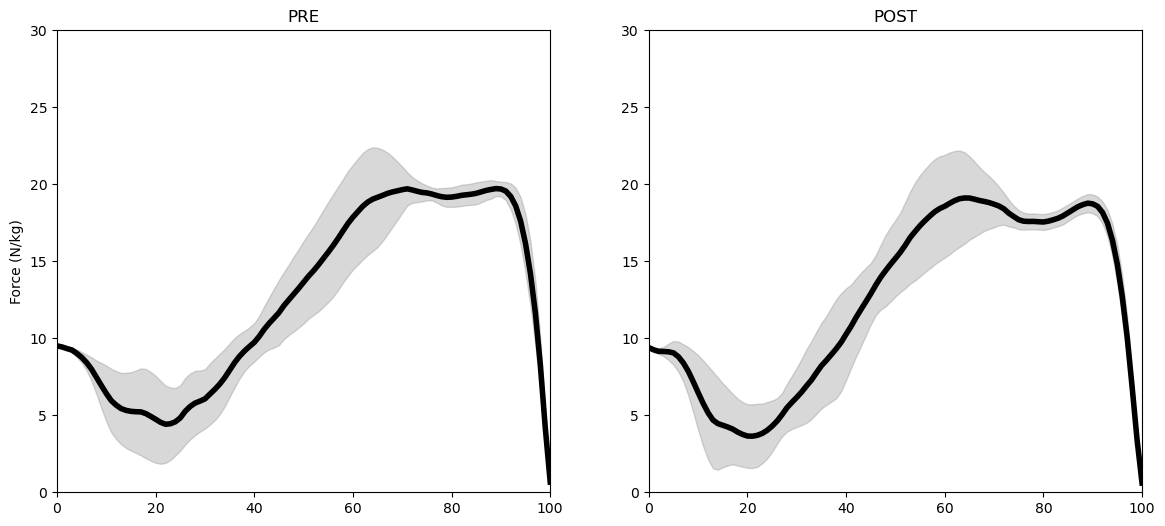

In [103]:
num_nodes = 101
y0_mean = y0.mean(axis = 0)
y0_std = y0.std(axis = 0)
x_vals = np.arange(num_nodes)

y1_mean = y1.mean(axis = 0)
y1_std = y1.std(axis = 0)


# plot mean and SD for fun
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
plt.plot(x_vals, y0_mean, color = 'black', linewidth = 4)
plt.fill_between(x_vals, y0_mean - y0_std, y0_mean + y0_std, color = 'grey', alpha = 0.3)
plt.xlim(0, 100)
plt.ylim(0, 30)
plt.ylabel('Force (N/kg)')
plt.title('PRE');

plt.subplot(1, 2, 2)
plt.plot(x_vals, y1_mean, color = 'black', linewidth = 4);
plt.fill_between(x_vals, y1_mean - y1_std, y1_mean + y1_std, color = 'grey', alpha = 0.3)
plt.xlim(0, 100)
plt.ylim(0, 30)
plt.title('POST');
